# <span style="color:#84b6f4;">Identificación de un actor específico</span>

### <span style="color:#77dd77;">Formación del DataFrame</span>

En este ejemplo, trataremos de entrenar un modelo que detecte la presencia de Will Smith en imágenes. Comenzamos creando el DataFrame con una serie de imágenes que se han recopilado, etiquetando como 1 las imágenes en las que aparece Will Smith y como 0 las imágenes en las que no aparece:

In [22]:
import pandas as pd
import os
import random

# Directorio en el que se encuentran las imágenes de Will Smith
will_directory = os.getcwd() + '/resources/actorImages/willSmith'

# Directorio en el que se encuentran las imágenes sin Will Smith
other_actors_directory = os.getcwd() + '/resources/actorImages/otherActors'

data = []

# Etiquetamos como 1 las imágenes en las que aparece Will Smith
for image in os.listdir(will_directory):
    image_url = os.path.join(will_directory, image)
    data.append({"image": image_url, "label": 1})

# Etiquetamos como 0 las imágenes en las que no aparece Will Smith
count = 0
for image in os.listdir(other_actors_directory):
    image_path = os.path.join(other_actors_directory, image)
    data.append({"image": image_path, "label": 0})
    count += 1

# Desordenamos aleatoriamente los datos
random.shuffle(data)

# Creamos el DataFrame
df = pd.DataFrame(data)

Cargamos las imágenes de entrada (los píxeles) y las etiquetas asociadas a cada imagen:

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 100

images = []
labels = []

# Cargamos las imágenes y etiquetas asociadas del DataFrame en "images" y "labels"
for i, row in df.iterrows():
    image_url = row['image']
    image = cv2.imread(image_url)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.reshape(IMG_SIZE, IMG_SIZE, 1)
    images.append(image)
    labels.append(row['label'])

images = np.array(images).astype(float) / 255
labels = np.array(labels)

### <span style="color:#77dd77;">Aumento de datos</span>

Aplicamos transformaciones de aumento de datos a las imágenes, para volver el conjunto de datos más diverso:

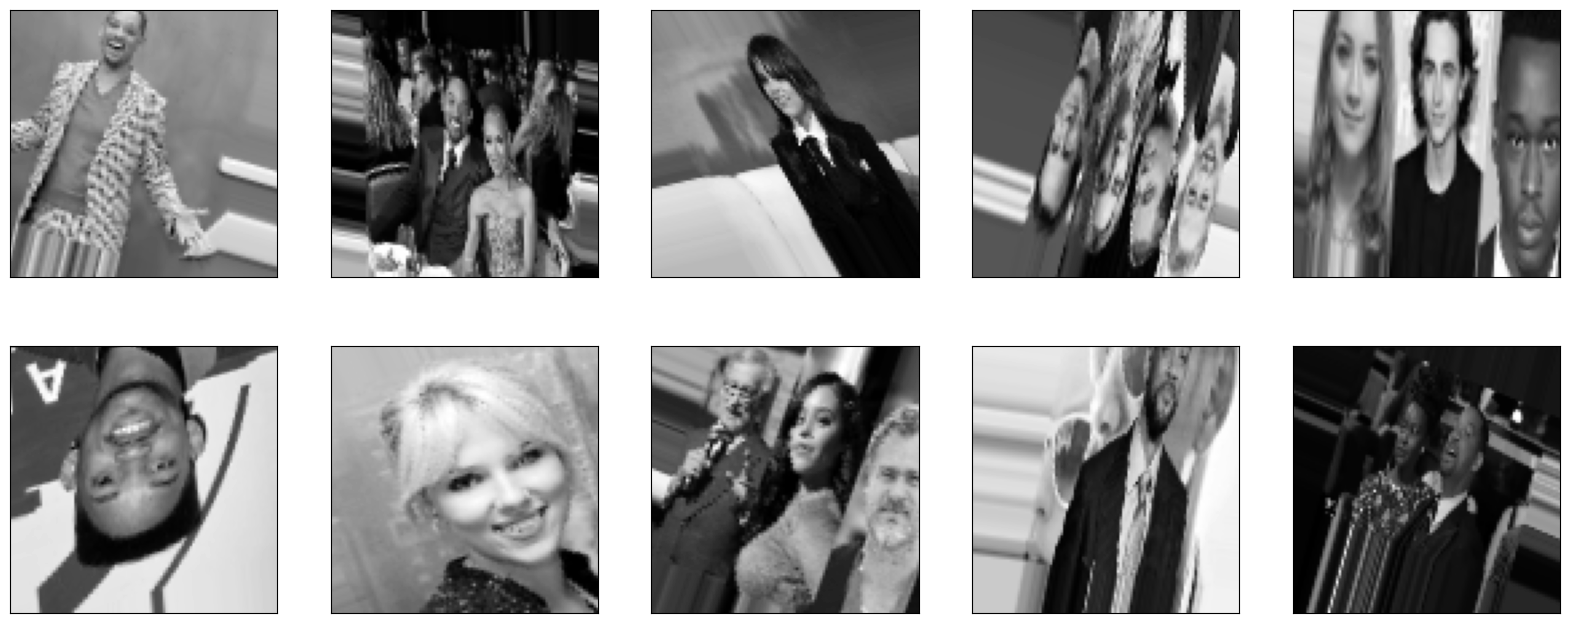

In [24]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

# Creamos un generador de imágenes aumentadas
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=15,
    zoom_range=[0.7, 1.4],
    horizontal_flip=True,
    vertical_flip=True
)

# Ajustamos el generador al conjunto de imágenes original
datagen.fit(images)

plt.figure(figsize=(20,8))

# Obtenemos un lote de imágenes aumentadas
for image, label in datagen.flow(images, labels, batch_size=10, shuffle=False):
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image[i].reshape(IMG_SIZE, IMG_SIZE), cmap="gray")
    break  # Rompemos el bucle después de mostrar un lote

Generamos más imágenes, para mejorar los resultados:

In [25]:
import numpy as np

# Separa las imágenes en dos grupos
images_will_smith = images[labels == 1]
labels_will_smith = labels[labels == 1]

images_others = images[labels == 0]
labels_others = labels[labels == 0]

# Imágenes que se van a generar para cada grupo
num_required = 900

# Función para aumentar un conjunto de imágenes y etiquetas
def augment_images(images, labels, num_required, datagen):
    num_transformations_per_image = np.ceil((num_required - len(images)) / len(images)).astype(int)
    augmented_images = []
    augmented_labels = []
    for x, y in zip(images, labels):
        for _ in range(num_transformations_per_image):
            for image_batch, label_batch in datagen.flow(x[None], y[None], batch_size=1):
                augmented_images.append(image_batch[0])
                augmented_labels.append(label_batch[0])
                break
        if len(augmented_images) + len(images) >= num_required:
            break
    return np.array(augmented_images), np.array(augmented_labels)

# Aplica el aumento a cada grupo
augmented_images_will, augmented_labels_will = augment_images(images_will_smith, labels_will_smith, num_required, datagen)
augmented_images_others, augmented_labels_others = augment_images(images_others, labels_others, num_required, datagen)

# Combina las imágenes originales y aumentadas para cada grupo
final_images_will = np.concatenate((images_will_smith, augmented_images_will), axis=0)
final_labels_will = np.concatenate((labels_will_smith, augmented_labels_will), axis=0)

final_images_others = np.concatenate((images_others, augmented_images_others), axis=0)
final_labels_others = np.concatenate((labels_others, augmented_labels_others), axis=0)

# Combina los grupos de vuelta en un solo conjunto
final_images = np.concatenate((final_images_will, final_images_others), axis=0)
final_labels = np.concatenate((final_labels_will, final_labels_others), axis=0)

print(len(final_images))

1800


### <span style="color:#77dd77;">Entrenamiento</span>

Creamos un modelo de red neuronal convolucional (CNN) y lo entrenamos:

In [26]:
from sklearn.model_selection import train_test_split

# Dividimos los datos en conjuntos de entrenamiento (70%) y prueba (30%)
# train_images, test_images, train_labels, test_labels = train_test_split(final_images, final_labels, test_size=0.3, random_state=42)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.3, random_state=42)


# Creamos el modelo CNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(250, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Configuramos el modelo para el entrenamiento
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamos el modelo
model.fit(
    datagen.flow(train_images, train_labels),
    epochs=100, batch_size=32,
    validation_data=(test_images, test_labels),
    steps_per_epoch=int(np.ceil(len(train_images) / float(32))),
    validation_steps=int(np.ceil(len(test_images) / float(32)))
)

Epoch 1/100
21/21 [==============================] - 5s 185ms/step - loss: 0.7094 - accuracy: 0.5350 - val_loss: 0.6901 - val_accuracy: 0.5088
Epoch 2/100
21/21 [==============================] - 4s 180ms/step - loss: 0.6858 - accuracy: 0.5304 - val_loss: 0.7056 - val_accuracy: 0.5088
Epoch 3/100
21/21 [==============================] - 4s 179ms/step - loss: 0.6839 - accuracy: 0.5593 - val_loss: 0.6795 - val_accuracy: 0.5654
Epoch 4/100
21/21 [==============================] - 4s 178ms/step - loss: 0.6937 - accuracy: 0.5441 - val_loss: 0.6809 - val_accuracy: 0.6184
Epoch 5/100
21/21 [==============================] - 4s 176ms/step - loss: 0.6831 - accuracy: 0.6049 - val_loss: 0.6813 - val_accuracy: 0.5442
Epoch 6/100
21/21 [==============================] - 4s 176ms/step - loss: 0.6884 - accuracy: 0.5486 - val_loss: 0.6809 - val_accuracy: 0.5442
Epoch 7/100
21/21 [==============================] - 4s 177ms/step - loss: 0.6629 - accuracy: 0.6064 - val_loss: 0.6676 - val_accuracy: 0.5654

### <span style="color:#77dd77;">Evaluación</span>

Evaluamos los resultados del modelo, utilizando métricas como la precisión, el F1-score y la matriz de confusión:

In [27]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Realizamos las predicciones con los datos de prueba
test_predictions = model.predict(test_images)
test_predictions_rounded = np.round(test_predictions)

# Evaluamos el modelo con diferentes métricas
accuracy = accuracy_score(test_labels, test_predictions_rounded)
f1 = f1_score(test_labels, test_predictions_rounded)
confusion = confusion_matrix(test_labels, test_predictions_rounded)

# Mostramos los resultados
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print(confusion)

9/9 [==============================] - 0s 31ms/step
Accuracy: 0.8374558303886925
F1 Score: 0.8380281690140845
[[118  26]
 [ 20 119]]


Para finalizar, exportamos el modelo:

In [28]:
from joblib import dump

# Guardamos el modelo
model_filename = 'will_smith_detection.joblib'
dump(model, model_filename)

['will_smith_detection.joblib']